In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec  # To customize subplot sizes

from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import ttest_ind

In [ ]:
path_data = "data/"
# Load the entire labelled dataset
df = pd.read_csv(path_data + "entire_dataset_labeled_final.csv")
# Filter the rows with labels == 1
df = df[df['labels'] == 1]

In [ ]:
df.head()

,author_id,created_at,retweet_count,reply_count,like_count,quote_count,lang,tweet,tweet_clean0,new_labels,labels
0,1221863565541494787,2020-12-01 00:35:08+00:00,0,0,1,0,fr,Les #GiletsJaunes de banlieue ont sentis avant...,Les #GiletsJaunes de banlieue ont sentis avant...,NaN,1
1,1314715851908620289,2020-12-01 00:08:07+00:00,0,0,0,0,fr,Le ministre de la santé belge a admis que la f...,Le ministre de la santé belge a admis que la f...,NaN,1
2,800457506203963392,2020-12-01 00:07:20+00:00,0,0,0,0,fr,💥#DictatureSanitaire #MortsEhpadsGVT #Confinem...,💥#DictatureSanitaire #MortsEhpadsGVT #Confinem...,NaN,1
3,1306909430764707840,2020-12-01 00:06:06+00:00,0,0,2,0,fr,"Il a parfaitement raison, on y va pas, on y es...","Il a parfaitement raison, on y va pas, on y es...",NaN,1
4,193392354,2020-12-01 01:41:03+00:00,0,0,2,0,fr,J'ai donné aux Entrepreneurs en Action du Québ...,J'ai donné aux Entrepreneurs en Action du Québ...,NaN,1


In [ ]:
df.labels.unique()

array([1])

In [ ]:
# Extract week information from the 'created_at' column
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.strftime('%Y-%U')

In [ ]:
#len(df[df["week"] == "2020-48"])

In [ ]:
#df = df.copy().loc[(df["week"] != "2020-48")]# & (df["week"] != "2022-05")]

In [ ]:
len(df)

338641

# I. Main Analysis - Use of pronouns in tweets and users (including hashtags)

# a) In tweets

In [ ]:
path_folder = ""

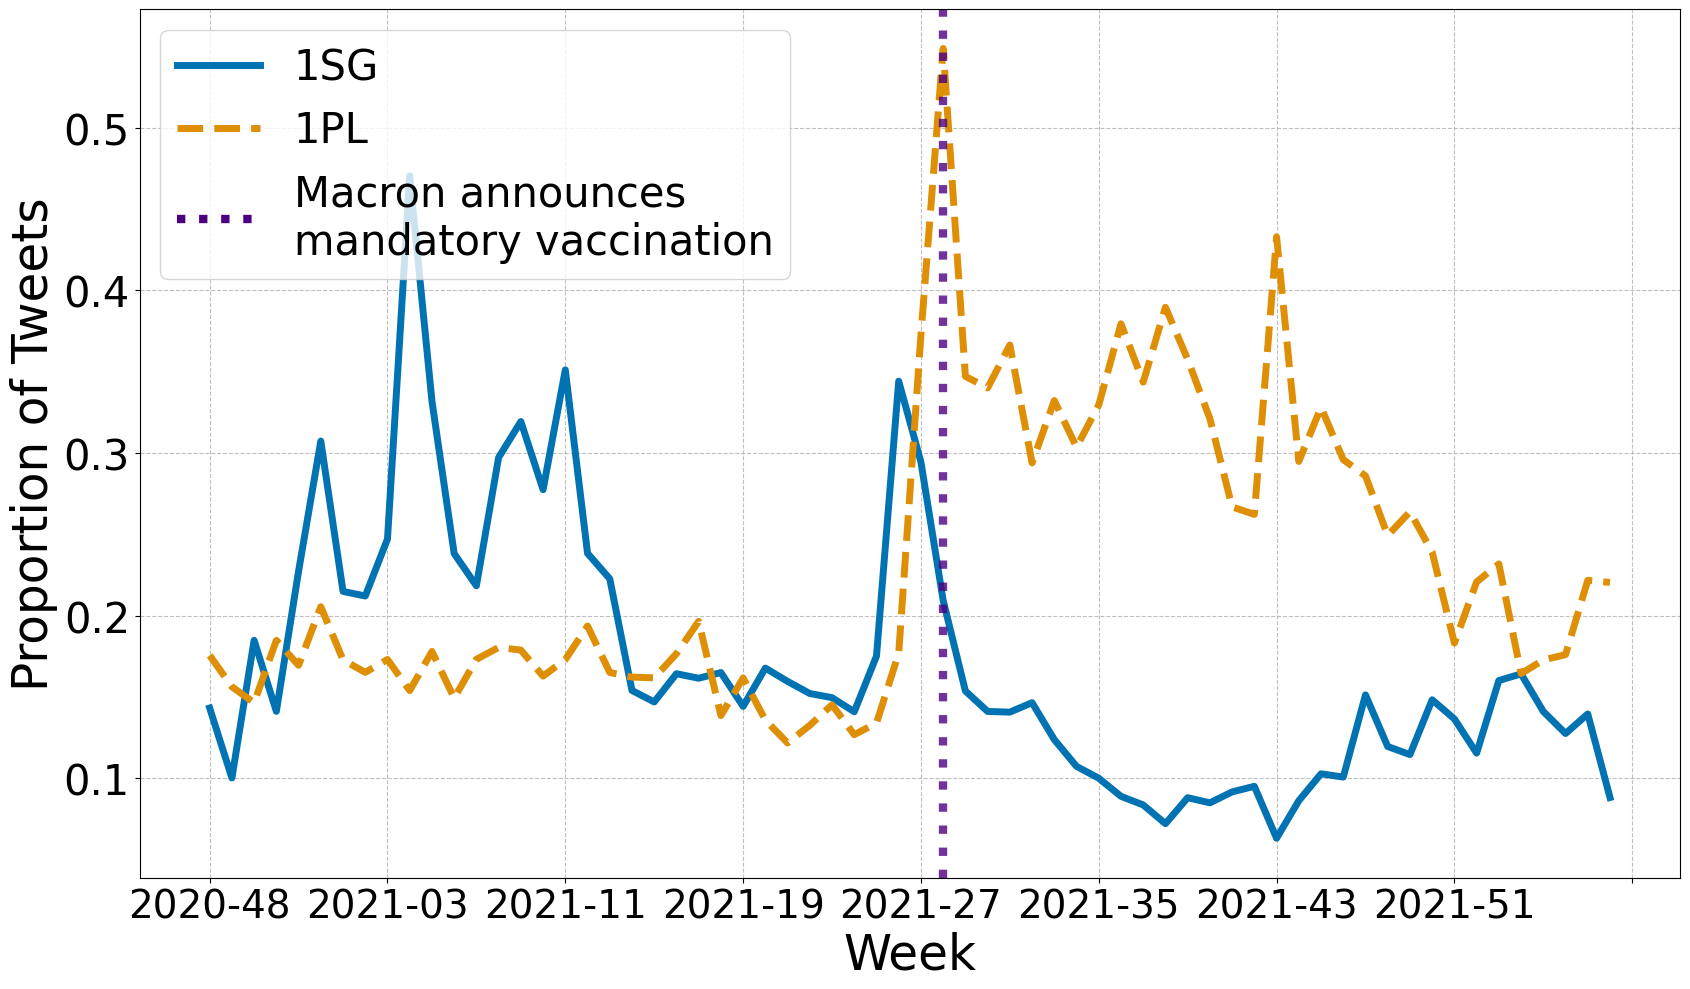

In [ ]:
# Define the list of pronouns to track
pronouns = [
    ["je", "j'", "me", "moi", "mien", "mienne", "miens", "miennes", "ma", "mon"],
    ["nous", "notre", "notres", "nôtre", "nôtres", "nos"]
]

# Initialize labels for each group of pronouns
all_labels = []

# Iterate through each group of pronouns
for group in pronouns:
    labels = []
    for tweet in df["tweet_clean0"].str.lower():
        has_pronoun = any(pronoun in tweet.replace("-", " ").split() for pronoun in group)
        has_hashtag = any(word.startswith(group[0]) for word in tweet.split("#")[1:])
        label = 1 if has_pronoun or has_hashtag else 0
        labels.append(label)
    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    df[f"Label_{i+1}"] = all_labels[i]

# Set a new color palette using seaborn
color_palette = sns.color_palette("colorblind")

# Define custom colors
highlight_line_color = '#4B0082'
highlight_fill_color = 'lightcoral'
line_color_1sg = color_palette[0]
line_color_1pl = color_palette[1]

# Define different line styles for the two pronoun groups
linestyle_1sg = '-'
linestyle_1pl = '--'

# Filter to keep only the relevant annotation for the event
relevant_week = '2021-28'  # Exact week for Macron's speech

# Ensure the 'week' column is sorted in the DataFrame and it's a string for comparison
df['week'] = df['week'].astype(str)

# Create the plot
fig, ax = plt.subplots(figsize=(17, 10))

legend_labels = ["1SG", "1PL"]

# Loop through each group of pronouns to calculate proportions and plot
for i in range(len(pronouns)):
    weekly_labels = df.groupby('week')[f"Label_{i+1}"].sum()
    total_tweets_per_week = df['week'].value_counts().sort_index()
    proportion_label_1 = weekly_labels / total_tweets_per_week

    if i == 0:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1sg, color=line_color_1sg, label=legend_labels[i], linewidth=5, zorder=2)
        # Add the dotted red line for Macron's speech below the other lines
        x_pos = proportion_label_1.index.get_loc(relevant_week)
        #ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

        # Extend the shaded area to the end of the x-axis (use the full range of the index)
        #ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
    else:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1pl, color=line_color_1pl, label=legend_labels[i], linewidth=5, zorder=2)

# Remove white space on the right side
#ax.set_xlim([-1, len(df['week'].unique())])
# Adjust the y-limit to give space above the lines for the legend
#y_max = proportion_label_1.max()  # Find the maximum y value across categories
#ax.set_ylim(0, y_max * 1.45)  # Increase y limit by 20% to make space for the legend

# Vertical line for Macron speech
ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=6, alpha=0.8)

# Customize the x-axis labels
ax.set_xlabel('Week', fontsize=35)
ax.set_ylabel('Proportion of Tweets', fontsize=35)

# Customize the grid and ticks
# Add grid
ax.grid(True, linestyle='--', alpha=0.8)
plt.xticks(fontsize=28)
plt.yticks(fontsize=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# Create a custom legend
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=5),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=5),
    mlines.Line2D([], [], color=highlight_line_color, linestyle='dotted', linewidth=6,
                  label='Macron announces\nmandatory vaccination')
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]
ax.legend(handles=handles, fontsize=30, loc='upper left')

plt.tight_layout()
plt.savefig(path_folder+"figures/proportion_pronounsgroups_use_low.png", dpi=200)
plt.show()

Average proportion of use of each group of pronouns before the cutoff date:
Label_1    0.221380
Label_2    0.186588
dtype: float64

Average proportion of use of each group of pronouns after the cutoff date:
Label_1    0.134884
Label_2    0.308405
dtype: float64
Z-test results for 1SG:
Z-statistic: 60.44997852438145
P-value: 0.0
The difference is statistically significant.

Z-test results for 1PL:
Z-statistic: -69.489684894503
P-value: 0.0
The difference is statistically significant.



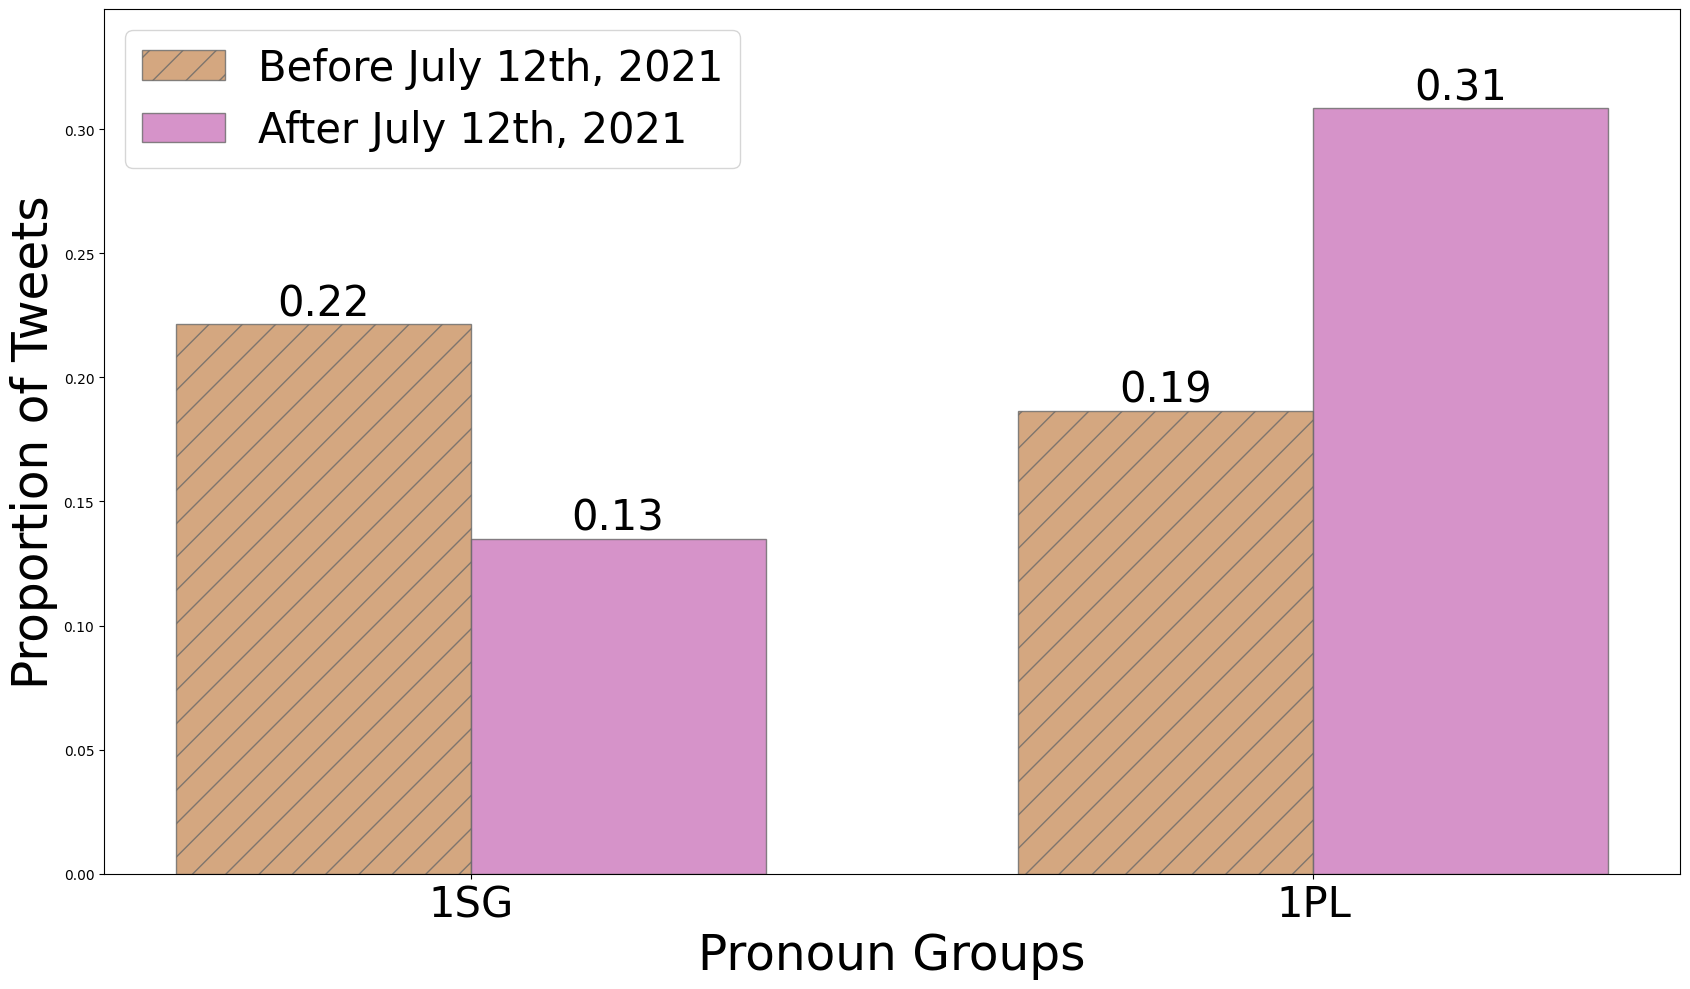

In [ ]:
# Use a colorblind-friendly palette from Seaborn
color_palette = sns.color_palette("colorblind")

df['created_at'] = pd.to_datetime(df['created_at'])

# Extract the date part from 'created_utc'
df['day'] = df['created_at'].dt.strftime('%Y-%m-%d')

# Define the cutoff date
cutoff_date = '2021-07-12'

# Filter data before and after the cutoff date
before_cutoff = df[df['day'] < cutoff_date]
after_cutoff = df[df['day'] > cutoff_date]

# Calculate the average proportion of use of each group of pronouns before and after the cutoff date
average_proportion_before = before_cutoff[[f"Label_{i+1}" for i in range(len(pronouns))]].mean()
average_proportion_after = after_cutoff[[f"Label_{i+1}" for i in range(len(pronouns))]].mean()

print("Average proportion of use of each group of pronouns before the cutoff date:")
print(average_proportion_before)

print("\nAverage proportion of use of each group of pronouns after the cutoff date:")
print(average_proportion_after)

# Perform proportion z-tests for each group of pronouns
z_test_results = {}
for i, label in enumerate(legend_labels):
    # Count the number of successes and trials
    before_successes = (before_cutoff[f"Label_{i+1}"] > 0).sum()
    before_trials = len(before_cutoff)
    after_successes = (after_cutoff[f"Label_{i+1}"] > 0).sum()
    after_trials = len(after_cutoff)

    # Perform the z-test
    count = np.array([before_successes, after_successes])
    nobs = np.array([before_trials, after_trials])
    z_statistic, p_value = proportions_ztest(count, nobs)
    z_test_results[label] = {'Z-statistic': z_statistic, 'P-value': p_value}

# Display z-test results
for label, result in z_test_results.items():
    print(f"Z-test results for {label}:")
    print(f"Z-statistic: {result['Z-statistic']}")
    print(f"P-value: {result['P-value']}")
    if result['P-value'] < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")
    print()

# Plotting side-by-side bar plots for each group of pronouns
plt.figure(figsize=(17, 10))
bar_width = 0.35  # Width of each bar
index = np.arange(len(legend_labels))  # Index for x-axis

# Plot bars for before and after cutoff with hatching
bars_before = plt.bar(index - bar_width/2, average_proportion_before.values, bar_width,
                      color=color_palette[5], alpha=0.8, hatch='/', label='Before July 12th, 2021', edgecolor="dimgrey")
bars_after = plt.bar(index + bar_width/2, average_proportion_after.values, bar_width,
                     color=color_palette[4], alpha=0.8, label='After July 12th, 2021', edgecolor="dimgrey")

# Add text annotations on the bars
for bars in [bars_before, bars_after]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.2f' % height, ha='center', va='bottom', fontsize=30)

# Add labels and titles
plt.xlabel('Pronoun Groups', fontsize=35)
plt.ylabel('Proportion of Tweets', fontsize=35)
plt.xticks(index, legend_labels, size=30)

# Adjust y-axis range and remove zero from the ticks
# Start from 0.05, excluding 0
plt.ylim(0, max(max(average_proportion_before), max(average_proportion_after)) + 0.04)  # Increase upper limit slightly

# Add a legend with increased font size
plt.legend(fontsize=30)

# Adjust layout for better fitting
plt.tight_layout()

# Save the plot
plt.savefig("figures/proportion_pronounsgroups_use_barplot_low.png", dpi=200)
plt.show()

## Between groups of users

In [ ]:
# Calculate the top 10% authors who publish the most
top_10_percent_authors = df['author_id'].value_counts().nlargest(int(len(df['author_id'].unique()) * 0.1)).index

# Filter the DataFrame based on the top 10% authors
df_top_10_percent = df[df['author_id'].isin(top_10_percent_authors)]

# Function to filter authors based on the new condition
def filter_activists(df):
    # Get the number of unique months each author has posted in
    author_post_months = df.groupby('author_id')['created_at'].apply(lambda x: x.dt.month.nunique())

    # Filter authors who have posted in every month
    prolific_authors = author_post_months[author_post_months >= 10].index

    # Filter the DataFrame based on prolific authors
    df_activists = df[df['author_id'].isin(prolific_authors)]

    return df_activists

# Apply the prolific condition to the original DataFrame
df_activists = filter_activists(df_top_10_percent)

# Define the start date (July 12th, 2021)
start_date = '2021-28'

# Get the first post date for each author in the entire dataset
first_post_dates = df.groupby('author_id')['week'].min()

# Identify authors who first posted on July 12th, 2021
first_post_july_12th = first_post_dates[first_post_dates == start_date].index

# Filter the dataset to include only authors who first posted on July 12th, 2021
authors_started_on_july_12th_df = df[df['author_id'].isin(first_post_july_12th)]

# Filter the dataset to include only authors who continued posting after July 12th, 2021
#authors_posted_after_july_12th = authors_posted_on_july_12th[authors_posted_on_july_12th['week'] > start_date]

# Filter the data to include only authors who posted after July 12th, 2021
#filtered_df_posted_after_july_12th = df[df['author_id'].isin(authors_posted_after_july_12th['author_id'])]

# Define the function to filter authors based on the new condition
def filter_authors_stopped(df, first_post_july_12th):
    # Get the last post date for each author in the entire dataset
    last_post_dates = df.groupby('author_id')['week'].max()

    # Identify authors who first posted on 2021-28 and never posted after
    last_post_july_12th = last_post_dates[last_post_dates == '2021-28'].index
    first_last_post_july_12th = list(set(last_post_july_12th).intersection(set(first_post_july_12th)))

    # Filter the dataset to include only authors who first posted on 2021-28 and never posted after
    authors_stopped_df = df[df['author_id'].isin(first_last_post_july_12th)]

    return authors_stopped_df

# Apply the new condition to the original DataFrame
authors_stopped_df = filter_authors_stopped(df, first_post_july_12th)

# Get the index of authors to be removed
authors_to_remove_index = authors_started_on_july_12th_df[authors_started_on_july_12th_df['author_id'].isin(authors_stopped_df['author_id'])].index

# Remove authors from authors_posted_on_july_12th
authors_continued_df = authors_started_on_july_12th_df.drop(authors_to_remove_index)

# Get the list of all author IDs in the DataFrame
all_authors = df['author_id'].unique()

# Get the list of authors who are prolific
activists_list = df_activists['author_id'].unique()

# Get the list of authors who started but did not continue
stopped_authors_list = authors_stopped_df['author_id'].unique()

# Get the list of authors who started and continue
continued_authors_list = authors_continued_df['author_id'].unique()

# # Create a list of authors not included in any of the other groups
# other_authors_list = [author for author in all_authors if author not in activists_list
#                       and author not in stopped_authors_list and author not in continued_authors_list]

# # Filter the DataFrame to include only authors in the "other" group
# df_other_authors = df[df['author_id'].isin(other_authors_list)]

# Step 1: Identify authors who started posting before 2021-28
authors_started_before_july_12th = first_post_dates[first_post_dates < '2021-28'].index

# Step 2: Ensure these authors are not part of the activists, stopped, or continued groups
# Create a set of authors who are not activists, stopped, or continued
excluded_authors = set(activists_list).union(stopped_authors_list).union(continued_authors_list)

# Filter out authors who are in the excluded groups
other_authors_list = [author for author in authors_started_before_july_12th if author not in excluded_authors]

# Step 3: Filter the DataFrame to include only authors in the "other" group
df_other_authors = df[df['author_id'].isin(other_authors_list)]

<ipython-input-17-d666efab8769>:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the legend at the bottom
<ipython-input-17-d666efab8769>:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the legend at the bottom


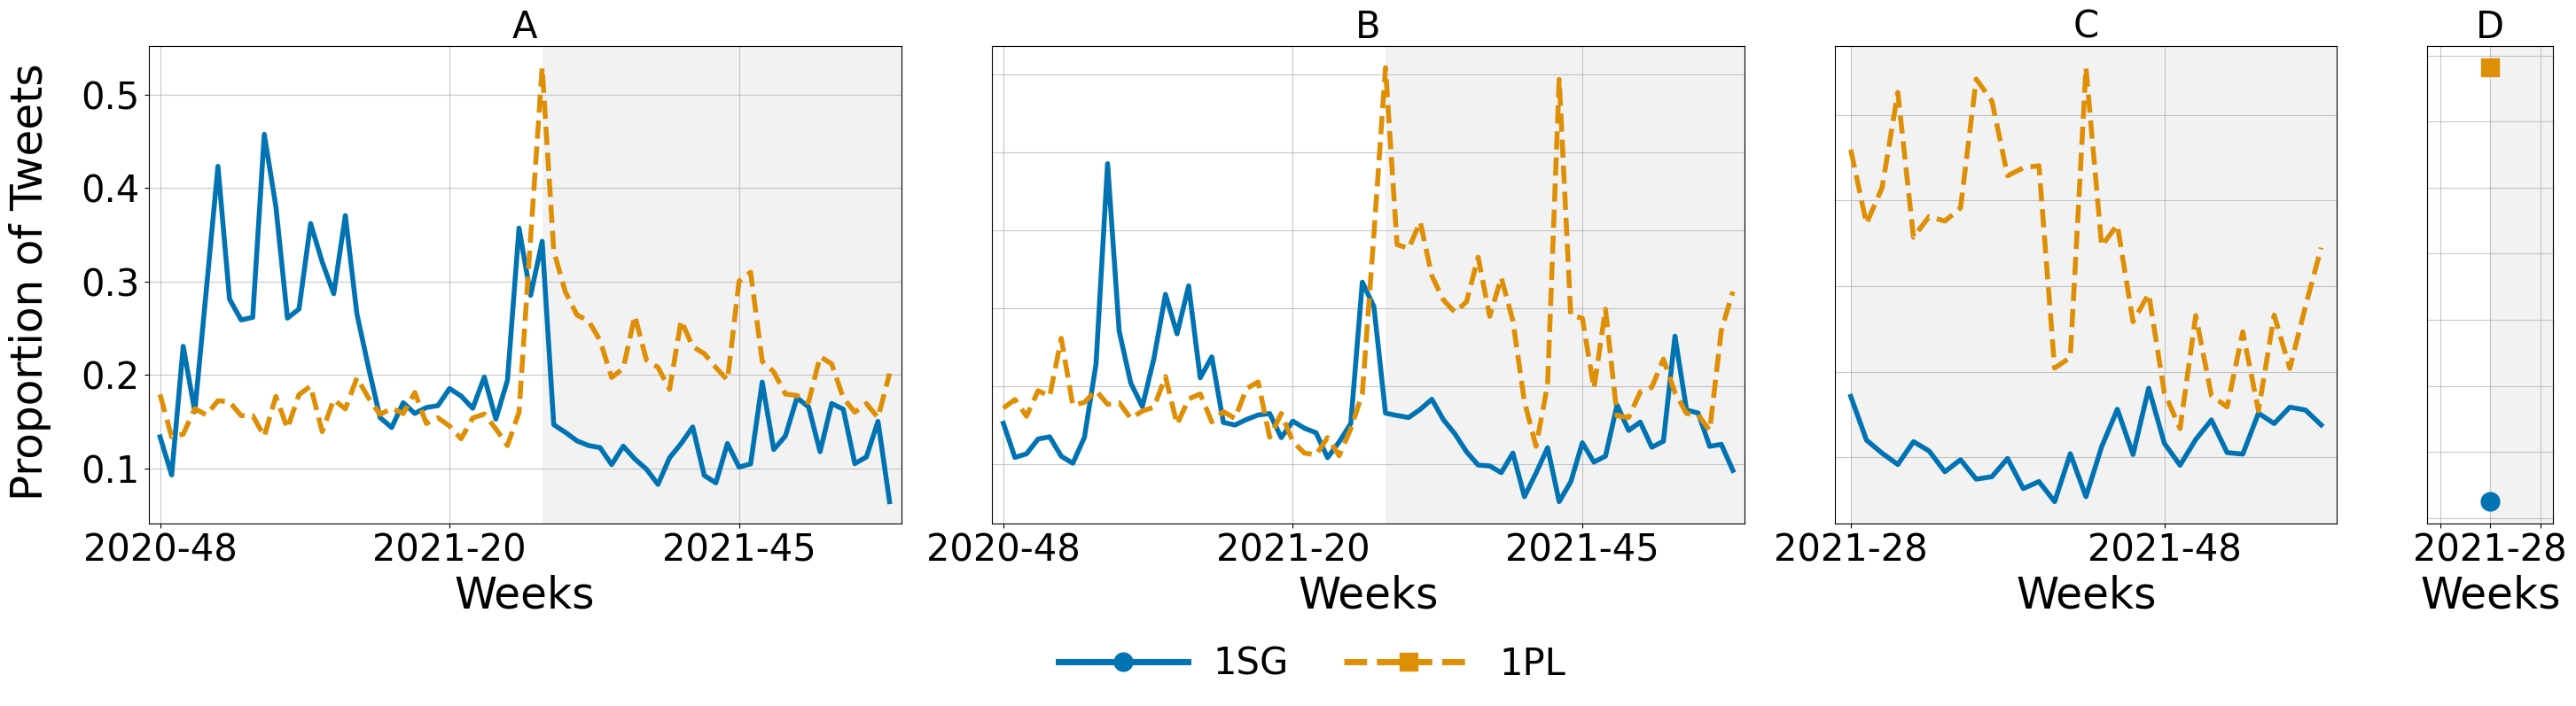

In [ ]:
markers = ['o', 's']

def plot_pronoun_use(ax, df, pronouns, legend_labels, numb, x_tick_size, max_x_locator,
                     single_tick=False, single_tick_position=None, single_tick_label=None):
    df = df.copy()  # Create a copy of the DataFrame to avoid SettingWithCopyWarning

    # Initialize labels for each group of pronouns
    all_labels = []

    # Iterate through each group of pronouns
    for group in pronouns:
        labels = []
        for tweet in df["tweet_clean0"].str.lower():
            has_pronoun = any(pronoun in tweet.replace("-", " ").split() for pronoun in group)
            has_hashtag = any(word.startswith(group[0]) for word in tweet.split("#")[1:])
            label = 1 if has_pronoun or has_hashtag else 0
            labels.append(label)
        all_labels.append(labels)

    # Create a DataFrame with the labels for each pronoun group
    for i, group in enumerate(pronouns):
        df[f"Label_{i+1}"] = all_labels[i]

    # Set a color palette using seaborn
    color_palette = sns.color_palette("colorblind")
    line_colors = [color_palette[i] for i in range(len(pronouns))]


    for i in range(len(pronouns)):
        weekly_labels = df.groupby('week')[f"Label_{i+1}"].sum()
        total_tweets_per_week = df['week'].value_counts().sort_index()
        proportion_label_1 = weekly_labels / total_tweets_per_week

        if i == 0:
            # Add the dotted red line for Macron's speech below the other lines
            x_pos = proportion_label_1.index.get_loc(relevant_week)

            # Extend the shaded area to the end of the x-axis (use the full range of the index)
            ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
            #ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

            if single_tick == False:
              ax.plot(proportion_label_1.index, proportion_label_1.values,
                linestyle=linestyle_1sg, color=line_colors[i],
                label=legend_labels[i], linewidth=4)
            else:
              ax.plot(proportion_label_1.index, proportion_label_1.values,
                marker=markers[i % len(markers)], linestyle='-', color=line_colors[i],
                label=legend_labels[i], linewidth=3, ms=15)
        else:
          if single_tick == False:
            ax.plot(proportion_label_1.index, proportion_label_1.values,
                linestyle=linestyle_1pl, color=line_colors[i],
                label=legend_labels[i], linewidth=4)
          else:
            ax.plot(proportion_label_1.index, proportion_label_1.values,
                marker=markers[i % len(markers)], linestyle='-', color=line_colors[i],
                label=legend_labels[i], linewidth=3, ms=15)

    # Customize grid, ticks, and labels
    ax.grid(True, alpha=0.7)
    ax.set_xlim([-1, len(proportion_label_1.index)])
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_x_locator))
    plt.setp(ax.get_xticklabels(), fontsize=x_tick_size)  # Control x-tick label size


# Create the main figure and a custom grid with different widths for each subplot
fig = plt.figure(constrained_layout=True, figsize=(35, 7))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[6, 6, 4, 1])  # Customize widths

# Reduce the width between subplots
gs.update(wspace=0.17)

# Define the axes for each subplot
ax1 = fig.add_subplot(gs[0, 0])  # Same size as ax2
ax2 = fig.add_subplot(gs[0, 1])  # Same size as ax1
ax3 = fig.add_subplot(gs[0, 2])  # Half the width of ax1 and ax2
ax4 = fig.add_subplot(gs[0, 3])  # One-fifth the width of ax1 and ax2

# Plot for the top 10% authors
plot_pronoun_use(ax1, df_activists, pronouns, legend_labels, numb=20, x_tick_size=30, max_x_locator=3, single_tick=False)
ax1.set_title("A", fontsize=30)

# Plot for other authors
plot_pronoun_use(ax2, df_other_authors, pronouns, legend_labels, numb=20, x_tick_size=30, max_x_locator=3, single_tick=False)
ax2.set_title("B", fontsize=30)

# Plot for continued authors
plot_pronoun_use(ax3, authors_continued_df, pronouns, legend_labels, numb=10, x_tick_size=30, max_x_locator=2, single_tick=False)
ax3.set_title("C", fontsize=30)

# Plot for authors who stopped
plot_pronoun_use(ax4, authors_stopped_df, pronouns, legend_labels, numb=1,
                 x_tick_size=30, max_x_locator=3, single_tick=True,
                 single_tick_position=0, single_tick_label="2021-28")
ax4.set_title("D", fontsize=30)

# Shared Y-axis label
fig.text(0.08, 0.5, 'Proportion of Tweets', va='center', rotation='vertical', fontsize=35)

# Remove y-ticks and labels from all subplots except the first one
for ax in [ax2, ax3, ax4]:
    ax.tick_params(left=False, labelleft=False)

# Set y-tick label size for ax1
plt.setp(ax1.get_yticklabels(), fontsize=30)

# Create a single legend for all plots and place it below the plots
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=5, marker=markers[0], ms=15),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=5, marker=markers[1], ms=15)
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]

fig.legend(handles=handles, loc='lower center', fontsize=30, ncol=2, frameon=False, handletextpad=0.7, columnspacing=1.5, handlelength=3.5, bbox_to_anchor=(0.5, -0.2))

# Adjust x-ticks and labels for each subplot (weeks)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Weeks", fontsize=35)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the legend at the bottom
plt.savefig("figures/proportion_pronounsgroups_use_combined_low.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
print(len(activists_list), len(stopped_authors_list), len(continued_authors_list), len(other_authors_list))

427 3321 2068 8931


# b) In users

In [ ]:
# Define the list of pronouns to track
pronouns = [
    ["je", "j'", "me", "moi", "mien", "mienne", "ma", "mon"],
    ["nous", "notre", "notres", "nôtre", "nôtres", "nos"]
]

# Initialize labels for each group of pronouns
all_labels = []

# Group tweets by author and week, and concatenate all tweets per author per week
grouped_df = df.groupby(['author_id', 'week'])['tweet_clean0'].apply(lambda x: ' '.join(x)).reset_index()

# Iterate through each group of pronouns
for group in pronouns:
    # Initialize labels for authors in each group
    labels = []

    # Iterate through the concatenated tweets of each author per week to assign labels for the current group
    for tweet in grouped_df["tweet_clean0"].str.lower():
        # Check if the concatenated tweet contains a pronoun or a hashtag starting with the first pronoun in the group
        has_pronoun = any(pronoun in tweet.replace("-", " ").split() for pronoun in group)
        has_hashtag = any(word.startswith(group[0]) for word in tweet.split("#")[1:])
        label = 1 if has_pronoun or has_hashtag else 0
        labels.append(label)

    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    grouped_df[f"Label_{i+1}"] = all_labels[i]

# Set a new color palette using seaborn
color_palette = sns.color_palette("colorblind")

# Define custom colors
highlight_line_color = 'darkred'
line_color_1sg = color_palette[0]
line_color_1pl = color_palette[1]

# Define different shapes for the lines
markers_1sg = 'o'
markers_1pl = 's'

# Filter to keep only the relevant annotation for the event
relevant_week = '2021-28'  # Exact week for Macron's speech

# Ensure the 'week' column is sorted in the DataFrame and it's a string for comparison
df['week'] = df['week'].astype(str)

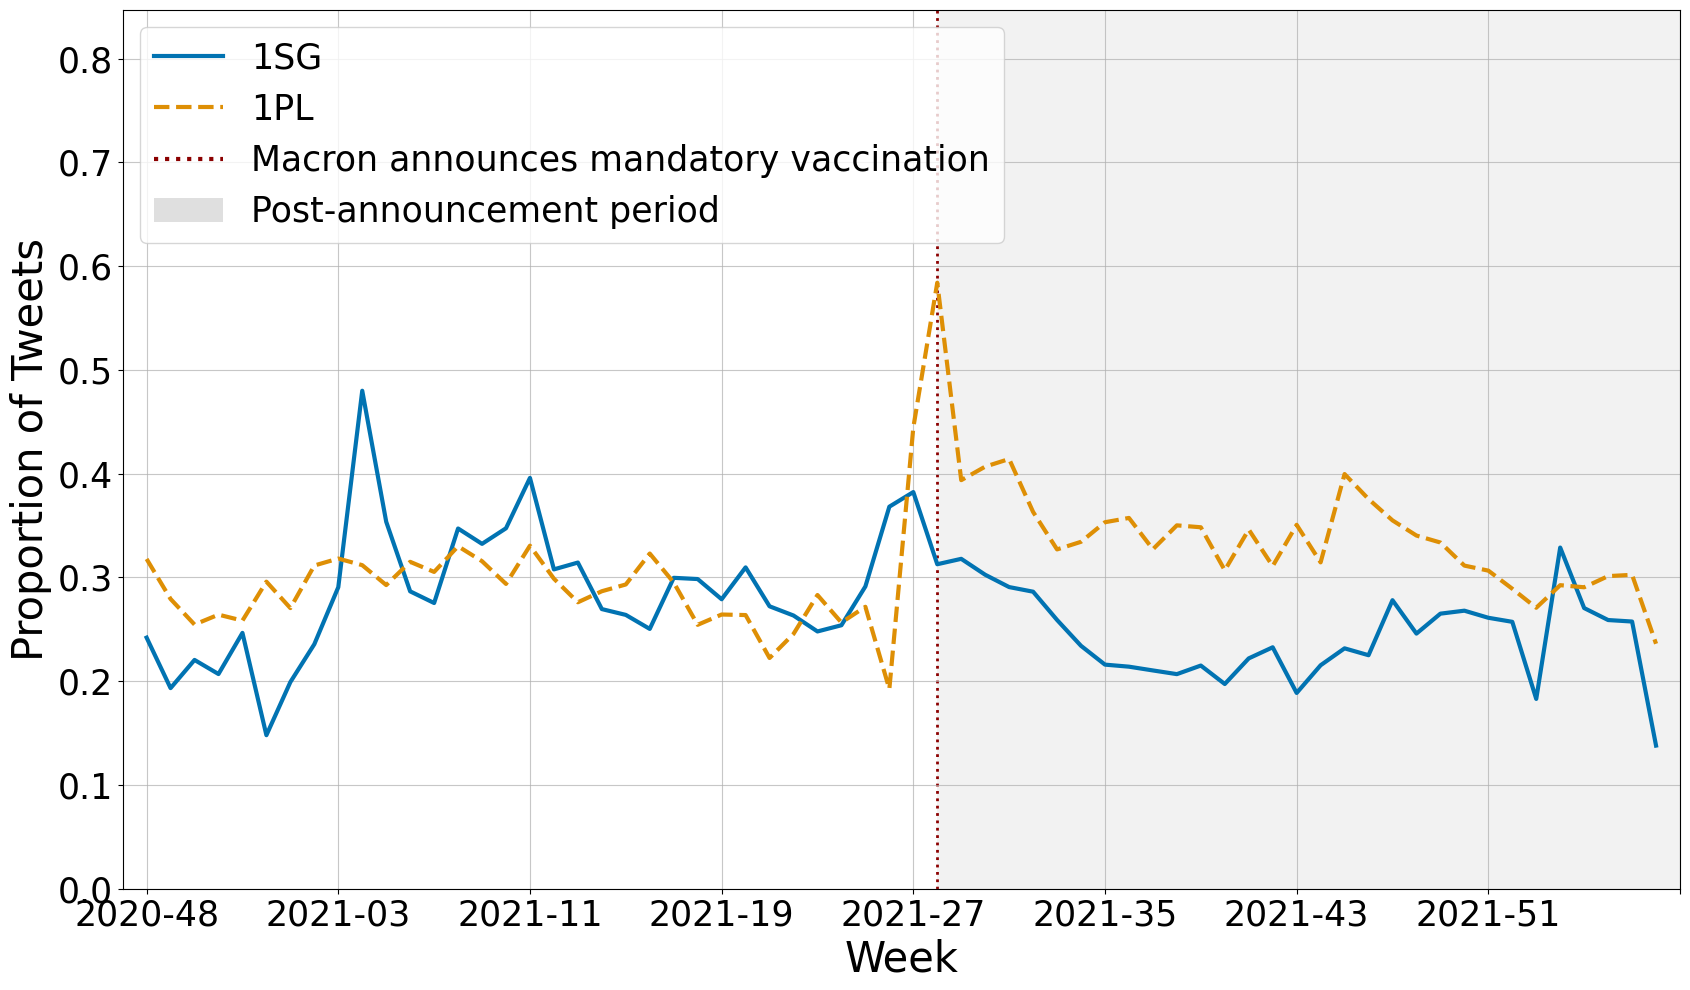

In [ ]:
# Group by week and calculate the proportion of authors with label 1 for each group of pronouns
fig, ax = plt.subplots(figsize=(17, 10))

legend_labels = ["1SG", "1PL"]

for i in range(len(pronouns)):
    weekly_labels = grouped_df.groupby('week')[f"Label_{i+1}"].sum()
    total_authors_per_week = grouped_df['week'].value_counts().sort_index()
    proportion_label_1 = weekly_labels / total_authors_per_week

    if i == 0:
        # Add the dotted red line for Macron's speech below the other lines
        x_pos = proportion_label_1.index.get_loc(relevant_week)
        ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

        # Extend the shaded area to the end of the x-axis (use the full range of the index)
        ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1sg, color=line_color_1sg, label=legend_labels[i], linewidth=3, zorder=2)
    else:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1pl, color=line_color_1pl, label=legend_labels[i], linewidth=3, zorder=2)

# Remove white space on the right side
ax.set_xlim([-1, len(df['week'].unique())])
# Adjust the y-limit to give space above the lines for the legend
y_max = proportion_label_1.max()  # Find the maximum y value across categories
ax.set_ylim(0, y_max * 1.45)  # Increase y limit by 20% to make space for the legend

# Customize the x-axis labels
ax.set_xlabel('Week', fontsize=30)
ax.set_ylabel('Proportion of Tweets', fontsize=30)

# Customize the grid and ticks
ax.grid(True, alpha=0.7)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# Create a custom legend
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=3),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=3),
    mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]
ax.legend(handles=handles, fontsize=25, loc='upper left')

plt.tight_layout()
#plt.savefig("figures/pronounsgroups_author_evolution_low.png", dpi=200)
plt.show()

Average proportion of use of each group of pronouns before the cutoff date:
Label_1    0.251269
Label_2    0.246705
dtype: float64

Average proportion of use of each group of pronouns after the cutoff date:
Label_1    0.206576
Label_2    0.311511
dtype: float64
T-test results for 1SG:
T-statistic: 19.24325211317292
P-value: 2.0142392554921093e-82
The difference is statistically significant.

T-test results for 1PL:
T-statistic: -25.42138197757716
P-value: 2.899526660144358e-142
The difference is statistically significant.



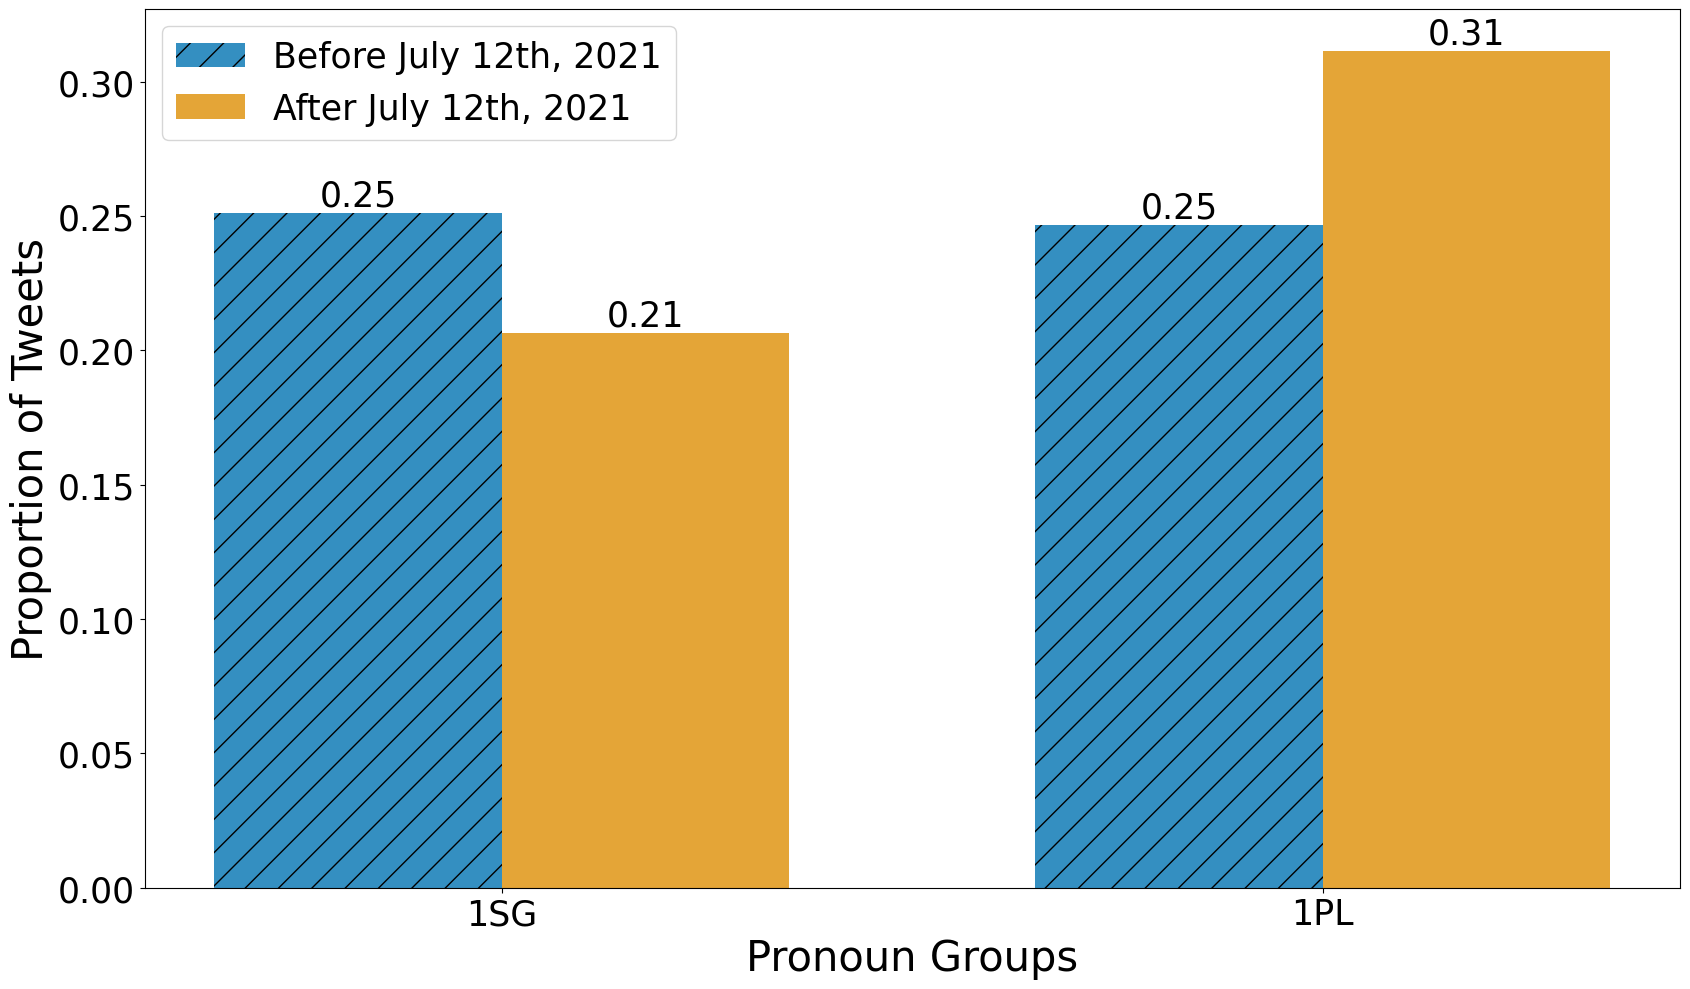

In [ ]:
# Use a colorblind-friendly palette from Seaborn
color_palette = sns.color_palette("colorblind")

df['created_at'] = pd.to_datetime(df['created_at'])

# Extract the date part from 'created_utc'
df['day'] = df['created_at'].dt.strftime('%Y-%m-%d')

# Define the cutoff date
cutoff_date = '2021-07-12'

# Initialize labels for each group of pronouns
all_labels = []

# Group tweets by author and week, and concatenate all tweets per author per week
grouped_df_day = df.groupby(['author_id', 'day'])['tweet_clean0'].apply(lambda x: ' '.join(x)).reset_index()

# Iterate through each group of pronouns
for group in pronouns:
    # Initialize labels for authors in each group
    labels = []

    # Iterate through the concatenated tweets of each author per week to assign labels for the current group
    for tweet in grouped_df_day["tweet_clean0"].str.lower():
        # Check if the concatenated tweet contains a pronoun or a hashtag starting with the first pronoun in the group
        has_pronoun = any(pronoun in tweet.replace("-", " ").split() for pronoun in group)
        has_hashtag = any(word.startswith(group[0]) for word in tweet.split("#")[1:])
        label = 1 if has_pronoun or has_hashtag else 0
        labels.append(label)

    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    grouped_df_day[f"Label_{i+1}"] = all_labels[i]

# Filter data before and after the cutoff date
before_cutoff = grouped_df_day[grouped_df_day['day'] < cutoff_date]
after_cutoff = grouped_df_day[grouped_df_day['day'] > cutoff_date]

# Calculate the average proportion of use of each group of pronouns before and after the cutoff date for authors
average_proportion_before = before_cutoff[[f"Label_{i+1}" for i in range(len(pronouns))]].mean()
average_proportion_after = after_cutoff[[f"Label_{i+1}" for i in range(len(pronouns))]].mean()

print("Average proportion of use of each group of pronouns before the cutoff date:")
print(average_proportion_before)

print("\nAverage proportion of use of each group of pronouns after the cutoff date:")
print(average_proportion_after)

# Perform t-tests for each group of pronouns
t_test_results = {}
for i, label in enumerate(legend_labels):
    t_statistic, p_value = ttest_ind(
        before_cutoff[f"Label_{i+1}"],
        after_cutoff[f"Label_{i+1}"]
    )
    t_test_results[label] = {'T-statistic': t_statistic, 'P-value': p_value}

# Display t-test results
for label, result in t_test_results.items():
    print(f"T-test results for {label}:")
    print(f"T-statistic: {result['T-statistic']}")
    print(f"P-value: {result['P-value']}")
    if result['P-value'] < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")
    print()

# Plotting side-by-side bar plots for each group of pronouns
plt.figure(figsize=(17, 10))
bar_width = 0.35  # Width of each bar
index = np.arange(len(legend_labels))  # Index for x-axis

# Plot bars for before and after cutoff with hatching
bars_before = plt.bar(index - bar_width/2, average_proportion_before.values, bar_width,
                      color=color_palette[0], alpha=0.8, hatch='/', label='Before July 12th, 2021')
bars_after = plt.bar(index + bar_width/2, average_proportion_after.values, bar_width,
                     color=color_palette[1], alpha=0.8, label='After July 12th, 2021')

# Add text annotations on the bars
for bars in [bars_before, bars_after]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.2f' % height, ha='center', va='bottom', fontsize=25)

# Add labels and titles
plt.xlabel('Pronoun Groups', fontsize=30)
plt.ylabel('Proportion of Tweets', fontsize=30)
#plt.title('Average Proportion of Use of Pronoun Groups Before and After Cutoff Date')
plt.xticks(index, legend_labels, size=25)
plt.yticks(size=25)

# Add a legend with increased font size
plt.legend(fontsize=25)

# Adjust layout for better fitting
plt.tight_layout()
#plt.savefig("figures/pronounsgroups_author_evolution_barplot_low.png", dpi=200)
plt.show()


# II - Additional checks

In [ ]:
# Assuming 'text' is the column containing the text with hashtags
df['hashtags_only'] = df['tweet_clean0'].str.findall(r'#\w+').apply(lambda x: ' '.join(x))
# Assuming 'text' is the column containing the text of the tweet
df['tweet_without_hashtags'] = df['tweet_clean0'].str.replace(r'#\w+', '')
df_no_only_hashtags = df[df['tweet_without_hashtags'].str.strip() != '']

# a) Without hashtags (for tweets and then users)

---



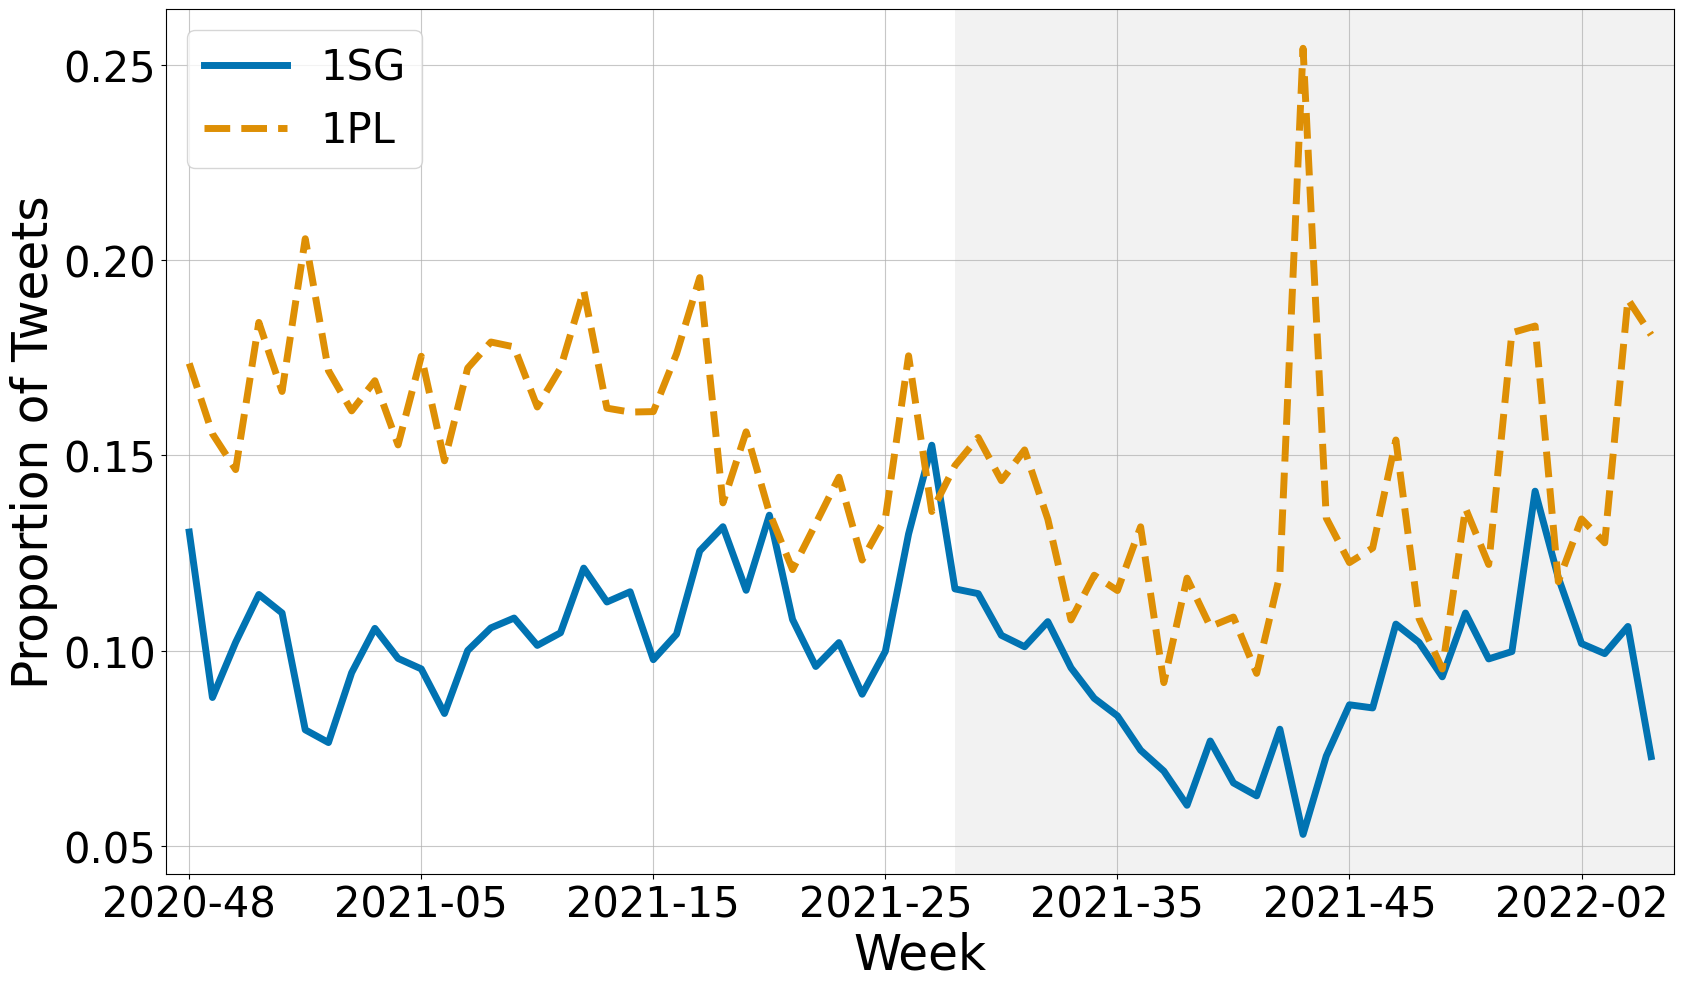

In [ ]:
# Initialize labels for each group of pronouns
all_labels = []

# Iterate through each group of pronouns
for group in pronouns:
    # Initialize labels for tweets in each group
    labels = []

    # Iterate through the tweets to assign labels for the current group
    for tweet in df_no_only_hashtags["tweet_without_hashtags"].str.lower():
        # Check if the tweet contains a pronoun or a hashtag starting with the first pronoun in the group
        has_pronoun = any(pronoun in tweet.replace("-", " ").split() for pronoun in group)
        label = 1 if has_pronoun else 0
        labels.append(label)

    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    df_no_only_hashtags[f"Label_{i+1}"] = all_labels[i]

# Create the plot
fig, ax = plt.subplots(figsize=(17, 10))

for i in range(len(pronouns)):
    weekly_labels = df_no_only_hashtags.groupby('week')[f"Label_{i+1}"].sum()
    total_tweets_per_week = df_no_only_hashtags['week'].value_counts().sort_index()
    proportion_label_1 = weekly_labels / total_tweets_per_week

    if i == 0:
        # Add the dotted red line for Macron's speech below the other lines
        x_pos = proportion_label_1.index.get_loc(relevant_week)
        #ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

        # Extend the shaded area to the end of the x-axis (use the full range of the index)
        ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1sg, color=line_color_1sg, label=legend_labels[i], linewidth=5, zorder=2)
    else:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1pl, color=line_color_1pl, label=legend_labels[i], linewidth=5, zorder=2)

# Remove white space on the right side
ax.set_xlim([-1, len(df['week'].unique())])

# Customize the x-axis labels
ax.set_xlabel('Week', fontsize=35)
ax.set_ylabel('Proportion of Tweets', fontsize=35)

# Customize the grid and ticks
ax.grid(True, alpha=0.7)
plt.xticks(fontsize=30)
plt.yticks([i for i in np.arange(0.05, 0.30, 0.05)], size=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

# Create a custom legend
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=5),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=5)
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]
ax.legend(handles=handles, fontsize=30, loc='upper left')

plt.tight_layout()
plt.savefig("figures/no_hashtags_pronouns_use_evolution_low.png", dpi=200)
plt.show()

Average proportion of use of each group of pronouns before the cutoff date:
Label_1    0.111079
Label_2    0.162083
dtype: float64

Average proportion of use of each group of pronouns after the cutoff date:
Label_1    0.099065
Label_2    0.137488
dtype: float64
T-test results for 1SG:
T-statistic: 10.108629473253483
P-value: 5.099462368008855e-24
The difference is statistically significant.

T-test results for 1PL:
T-statistic: 17.864243423301687
P-value: 2.4193027849562184e-71
The difference is statistically significant.



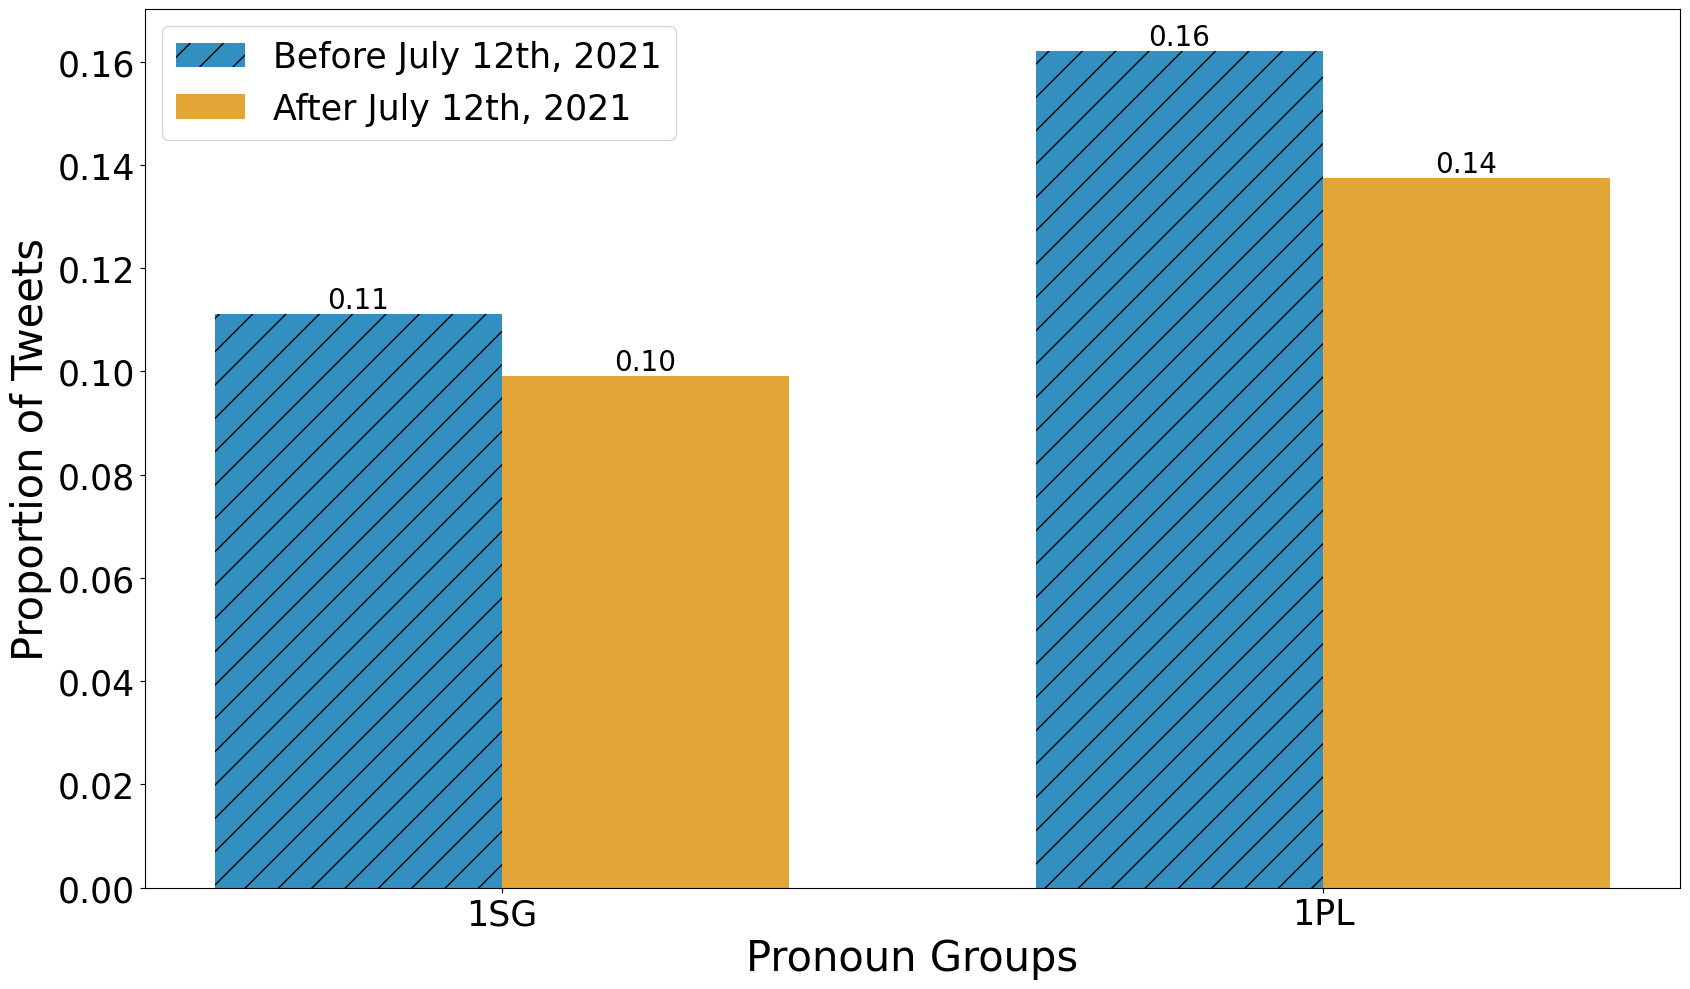

In [ ]:
df_no_only_hashtags['created_at'] = pd.to_datetime(df_no_only_hashtags['created_at'])

# Extract the date part from 'created_utc'
df_no_only_hashtags['day'] = df_no_only_hashtags['created_at'].dt.strftime('%Y-%m-%d')

# Define the cutoff date
cutoff_date = '2021-07-12'

# Filter data before and after the cutoff date
before_cutoff = df_no_only_hashtags[df_no_only_hashtags['day'] < cutoff_date]
after_cutoff = df_no_only_hashtags[df_no_only_hashtags['day'] > cutoff_date]

# Calculate the average proportion of use of each group of pronouns before and after the cutoff date
average_proportion_before = before_cutoff[[f"Label_{i+1}" for i in range(len(pronouns))]].mean()
average_proportion_after = after_cutoff[[f"Label_{i+1}" for i in range(len(pronouns))]].mean()

print("Average proportion of use of each group of pronouns before the cutoff date:")
print(average_proportion_before)

print("\nAverage proportion of use of each group of pronouns after the cutoff date:")
print(average_proportion_after)

# Perform t-tests for each group of pronouns
t_test_results = {}
for i, label in enumerate(legend_labels):
    t_statistic, p_value = ttest_ind(
        before_cutoff[f"Label_{i+1}"],
        after_cutoff[f"Label_{i+1}"]
    )
    t_test_results[label] = {'T-statistic': t_statistic, 'P-value': p_value}

# Display t-test results
for label, result in t_test_results.items():
    print(f"T-test results for {label}:")
    print(f"T-statistic: {result['T-statistic']}")
    print(f"P-value: {result['P-value']}")
    if result['P-value'] < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")
    print()

# Plotting side-by-side bar plots for each group of pronouns
plt.figure(figsize=(17, 10))
bar_width = 0.35  # Width of each bar
index = np.arange(len(legend_labels))  # Index for x-axis

# Plot bars for before and after cutoff with hatching
bars_before = plt.bar(index - bar_width/2, average_proportion_before.values, bar_width,
                      color=color_palette[0], alpha=0.8, hatch='/', label='Before July 12th, 2021')
bars_after = plt.bar(index + bar_width/2, average_proportion_after.values, bar_width,
                     color=color_palette[1], alpha=0.8, label='After July 12th, 2021')

# Add text annotations on the bars
for bars in [bars_before, bars_after]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.2f' % height, ha='center', va='bottom', fontsize=20)

# Add labels and titles
plt.xlabel('Pronoun Groups', fontsize=30)
plt.ylabel('Proportion of Tweets', fontsize=30)
#plt.title('Average Proportion of Use of Pronoun Groups Before and After Cutoff Date')
plt.xticks(index, legend_labels, size=25)
plt.yticks(size=25)

# Add a legend with increased font size
plt.legend(fontsize=25)

# Adjust layout for better fitting
plt.tight_layout()
#plt.savefig("figures/no_hashtags_pronouns_use_barplot_low.png", dpi=200)
plt.show()

In [ ]:
# Assuming 'text' is the column containing the text with hashtags
grouped_df['hashtags_only'] = grouped_df['tweet_clean0'].str.findall(r'#\w+').apply(lambda x: ' '.join(x))
# Assuming 'text' is the column containing the text of the tweet
grouped_df['tweet_without_hashtags'] = grouped_df['tweet_clean0'].str.replace(r'#\w+', '')
grouped_df_no_only_hashtags = grouped_df[grouped_df['tweet_without_hashtags'].str.strip() != '']

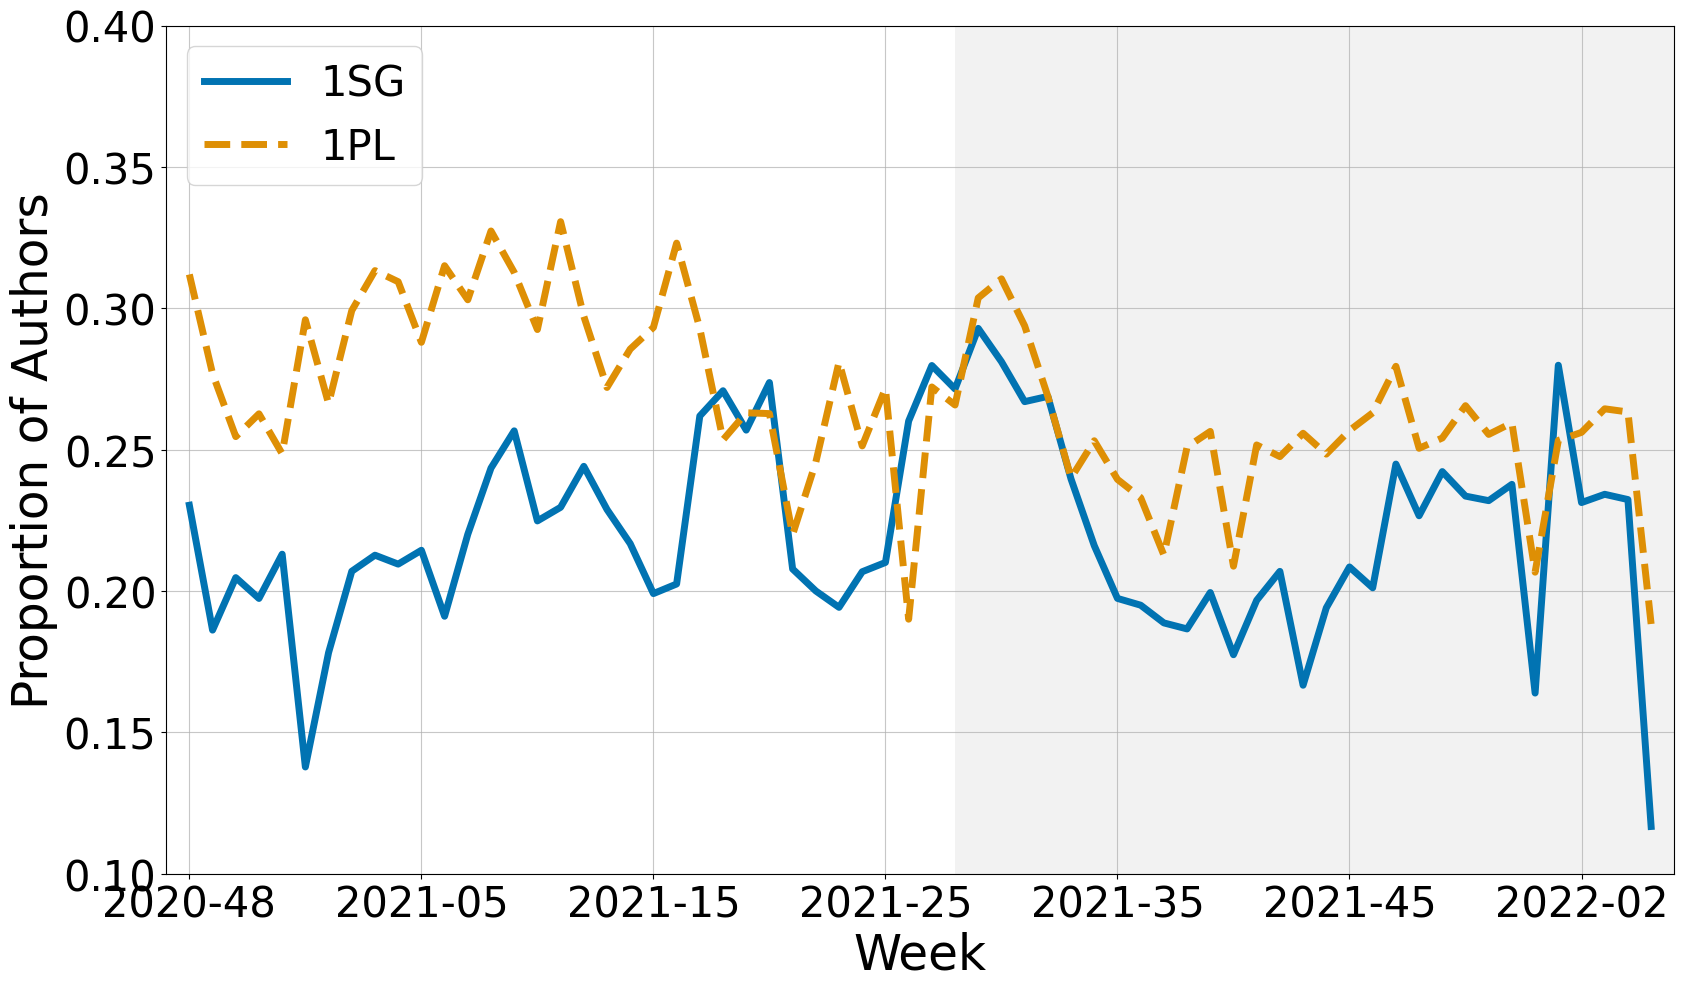

In [ ]:
# Initialize labels for each group of pronouns
all_labels = []

# Iterate through each group of pronouns
for group in pronouns:
    # Initialize labels for tweets in each group
    labels = []

    # Iterate through the tweets to assign labels for the current group
    for tweet in grouped_df_no_only_hashtags["tweet_without_hashtags"].str.lower():
        # Check if the tweet contains a pronoun or a hashtag starting with the first pronoun in the group
        has_pronoun = any(pronoun in tweet.replace("-", " ").split() for pronoun in group)
        label = 1 if has_pronoun else 0
        labels.append(label)

    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    grouped_df_no_only_hashtags[f"Label_{i+1}"] = all_labels[i]

# Group by week and calculate the proportion of tweets with label 1 for each group of pronouns
fig, ax = plt.subplots(figsize=(17, 10))

for i in range(len(pronouns)):
    weekly_labels = grouped_df_no_only_hashtags.groupby('week')[f"Label_{i+1}"].sum()
    total_tweets_per_week = grouped_df_no_only_hashtags['week'].value_counts().sort_index()
    proportion_label_1 = weekly_labels / total_tweets_per_week

    if i == 0:
        # Add the dotted red line for Macron's speech below the other lines
        x_pos = proportion_label_1.index.get_loc(relevant_week)
        #ax.axvline(x=x_pos, color=highlight_line_color, linestyle='--', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

        # Extend the shaded area to the end of the x-axis (use the full range of the index)
        ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1sg, color=line_color_1sg, label=legend_labels[i], linewidth=5, zorder=2)
    else:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1pl, color=line_color_1pl, label=legend_labels[i], linewidth=5, zorder=2)

# Remove white space on the right side
ax.set_xlim([-1, len(df['week'].unique())])

grouped_df_no_only_hashtags = grouped_df_no_only_hashtags.sort_values("week")

# Customize the x-axis labels
ax.set_xlabel('Week', fontsize=35)
ax.set_ylabel('Proportion of Authors', fontsize=35)

# Customize the grid and ticks
ax.grid(True, alpha=0.7)
plt.xticks(fontsize=30)
plt.yticks([i for i in np.arange(0.10, 0.4, 0.05)], size=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

# Create a custom legend
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=5),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=5)
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]
ax.legend(handles=handles, fontsize=30, loc='upper left')

plt.tight_layout()
#plt.savefig("figures/no_hashtags_authors_pronouns_use_evolution_low.png", dpi=200)
plt.show()

# b) Only hashtags

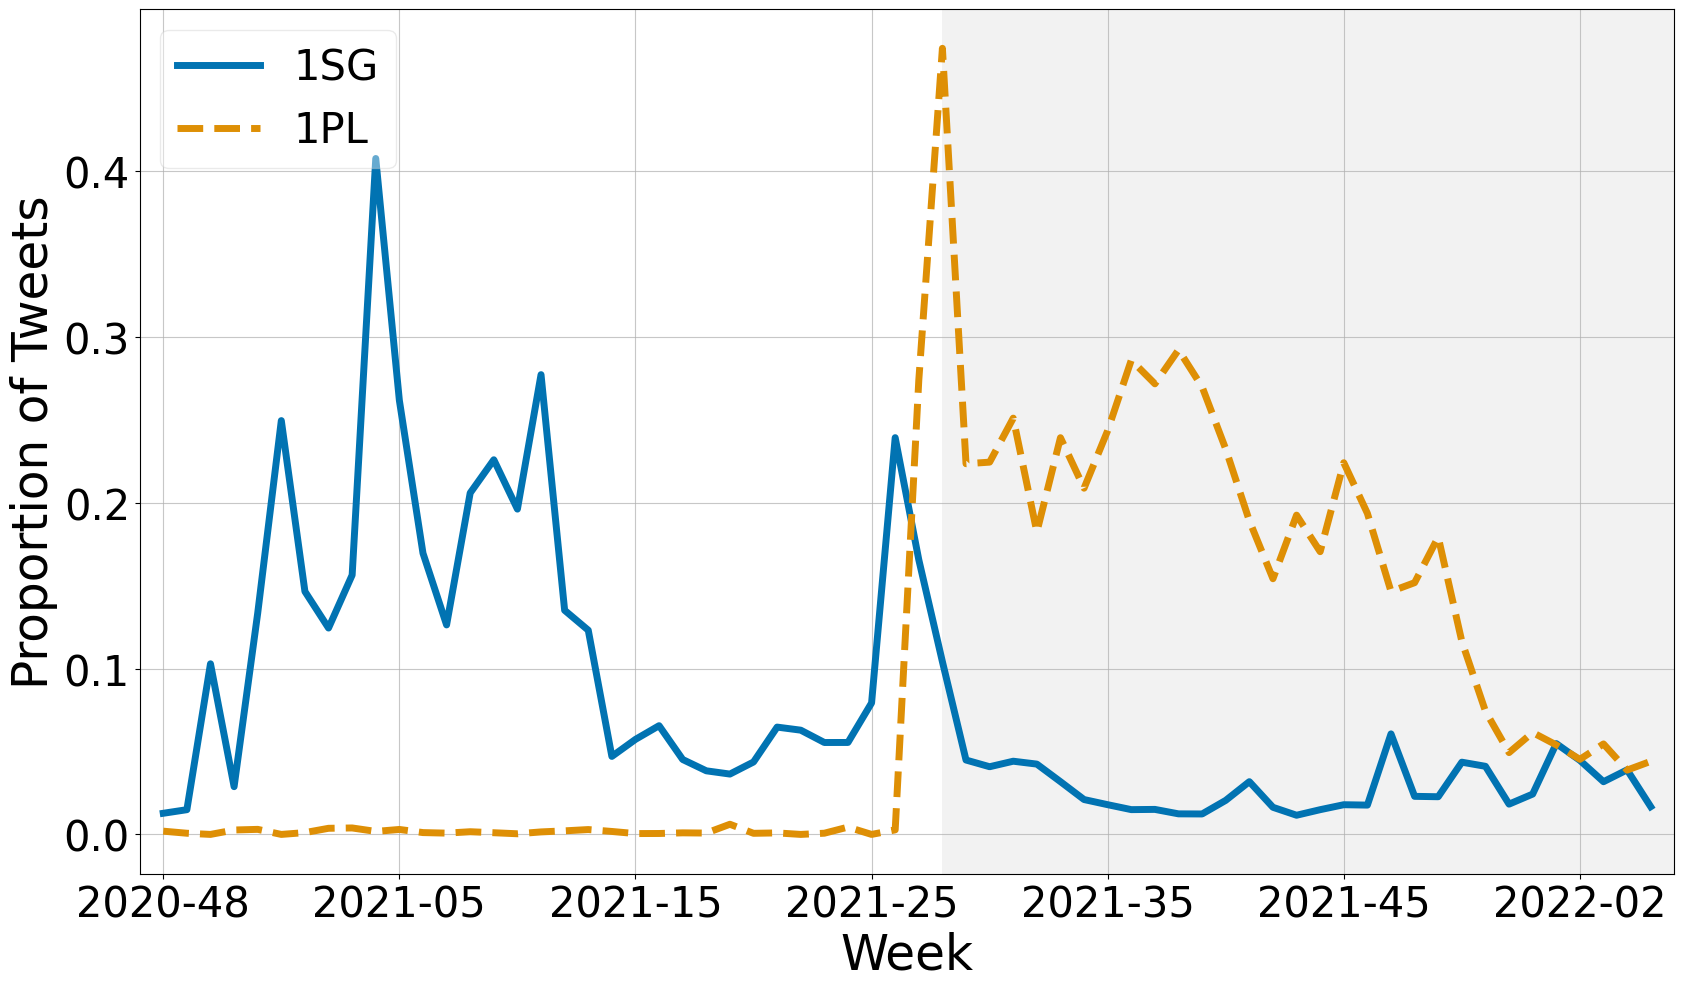

In [ ]:
# Initialize labels for each group of pronouns
all_labels = []

# Iterate through each group of pronouns
for group in pronouns:
    # Initialize labels for tweets in each group
    labels = []

    # Iterate through the tweets to assign labels for the current group
    for tweet in df["hashtags_only"].str.lower():
        # Check if the tweet contains a pronoun or a hashtag starting with the first pronoun in the group
        has_hashtag = any(word.startswith(group[0]) for word in tweet.split("#")[1:])
        label = 1 if has_hashtag else 0
        labels.append(label)

    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    df[f"Label_{i+1}"] = all_labels[i]

# Group by week and calculate the proportion of tweets with label 1 for each group of pronouns
fig, ax = plt.subplots(figsize=(17, 10))

for i in range(len(pronouns)):
    weekly_labels = df.groupby('week')[f"Label_{i+1}"].sum()
    total_tweets_per_week = df['week'].value_counts().sort_index()
    proportion_label_1 = weekly_labels / total_tweets_per_week

    if i == 0:
        # Add the dotted red line for Macron's speech below the other lines
        x_pos = proportion_label_1.index.get_loc(relevant_week)
        #ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

        # Extend the shaded area to the end of the x-axis (use the full range of the index)
        ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1sg, color=line_color_1sg, label=legend_labels[i], linewidth=5, zorder=2)
    else:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1pl, color=line_color_1pl, label=legend_labels[i], linewidth=5, zorder=2)

# Remove white space on the right side
ax.set_xlim([-1, len(df['week'].unique())])

grouped_df_no_only_hashtags = grouped_df_no_only_hashtags.sort_values("week")

# Customize the x-axis labels
ax.set_xlabel('Week', fontsize=35)
ax.set_ylabel('Proportion of Tweets', fontsize=35)

# Customize the grid and ticks
ax.grid(True, alpha=0.7)
plt.xticks(fontsize=30)
plt.yticks(size=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

# Create a custom legend
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=5),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=5)
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]
ax.legend(handles=handles, fontsize=30, loc='upper left', framealpha=0.4)

plt.tight_layout()
plt.savefig("figures/only_hashtags_pronouns_use_evolution_low.png", dpi=200)
plt.show()

# c) Only hashtags but excluding the ones used for data collection

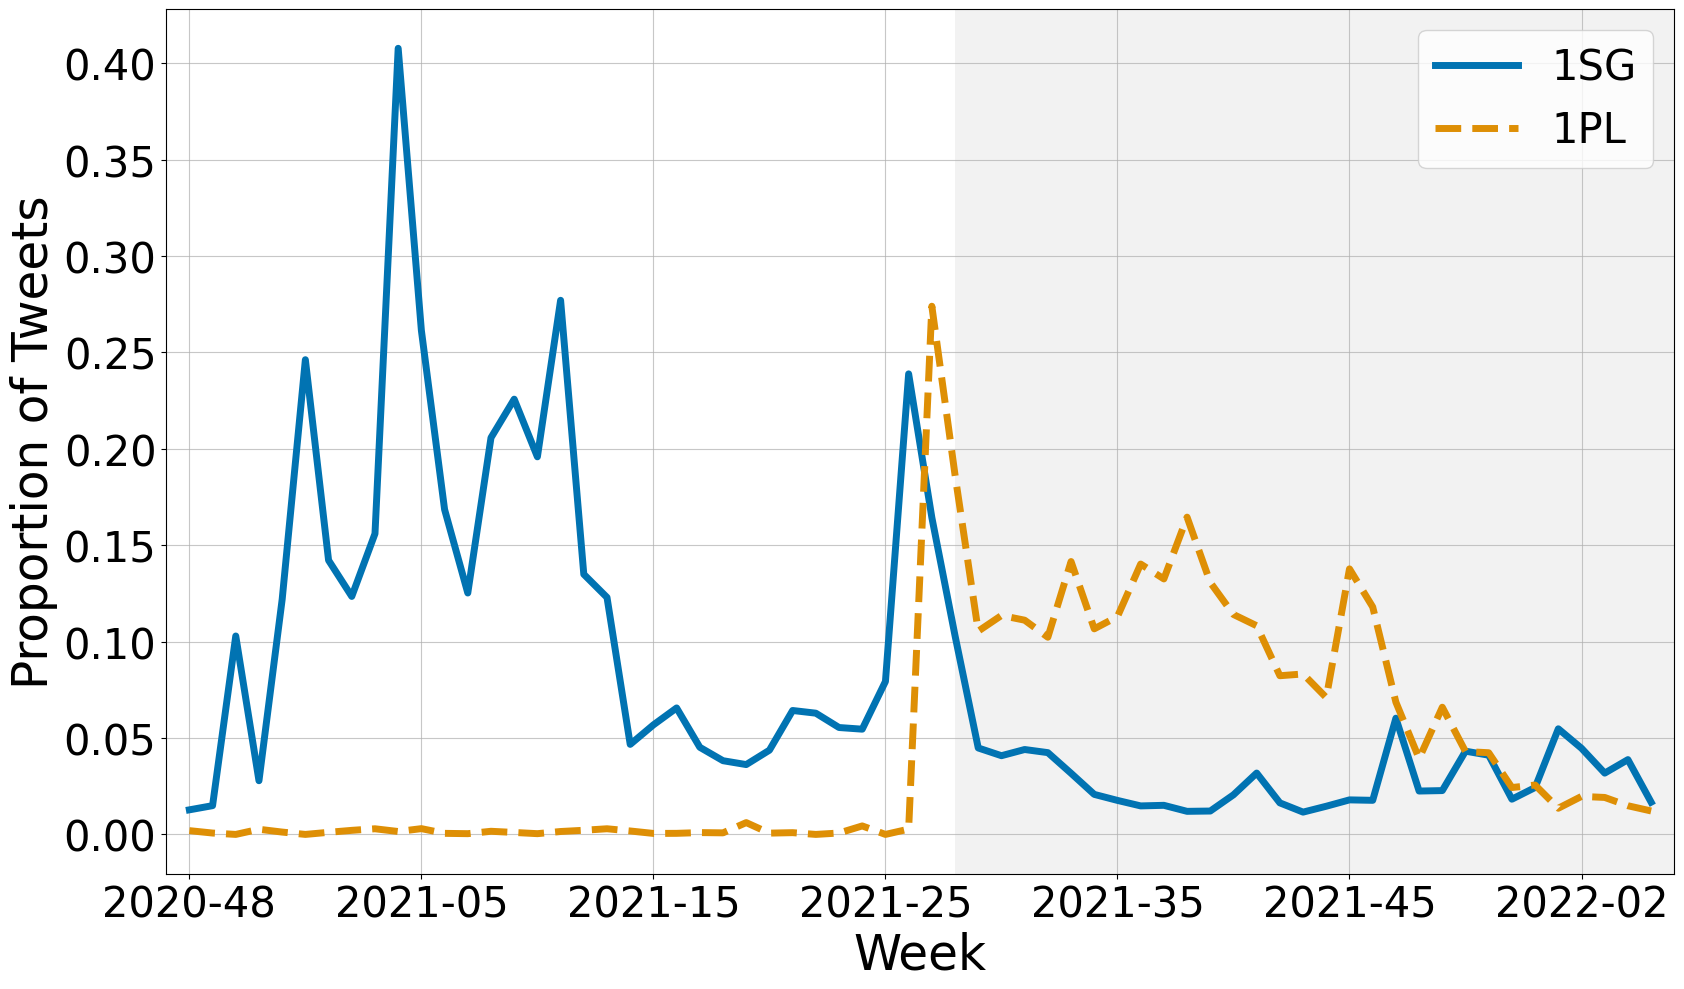

In [ ]:
# Define the list of hashtags to exclude
excluded_hashtags = [
    "#passSanitaire", "#vaccinationObligatoire", "#antivax", "#antivaccin", "#antivaxx",
    "#nonauvaccin", "#jenemefaispasvacciner", "#JeNeMeFeraisPasVacciner", "#Passdelahonte",
    "#NonauPassdelahonte", "#NonaupassSanitaire", "#NonAuPassVaccinal", "#DictatureSanitaire",
    "#StopDictatureSanitaire", "#NousSommesDesMillions"
]
excluded_hashtags = [word.lower() for word in excluded_hashtags]

# Initialize labels for each group of pronouns
all_labels = []

# Iterate through each group of pronouns
for group in pronouns:
    # Initialize labels for tweets in each group
    labels = []

    # Iterate through the tweets to assign labels for the current group
    for tweet in df["hashtags_only"].str.lower():
        # Check if the tweet contains a pronoun or a hashtag starting with the first pronoun in the group
        #has_hashtag = any(group[0] in word for word in tweet.lower().split() if word.lower() not in excluded_hashtags)
        has_hashtag = any(word.startswith("#" + group[0]) for word in tweet.lower().split() if word not in excluded_hashtags)
        label = 1 if has_hashtag else 0
        labels.append(label)

    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    df[f"Label_{i+1}"] = all_labels[i]

# Group by week and calculate the proportion of tweets with label 1 for each group of pronouns
fig, ax = plt.subplots(figsize=(17, 10))

for i in range(len(pronouns)):
    weekly_labels = df.groupby('week')[f"Label_{i+1}"].sum()
    total_tweets_per_week = df['week'].value_counts().sort_index()
    proportion_label_1 = weekly_labels / total_tweets_per_week

    if i == 0:
        # Add the dotted red line for Macron's speech below the other lines
        x_pos = proportion_label_1.index.get_loc(relevant_week)
        #ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

        # Extend the shaded area to the end of the x-axis (use the full range of the index)
        ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1sg, color=line_color_1sg, label=legend_labels[i], linewidth=5, zorder=2)
    else:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1pl, color=line_color_1pl, label=legend_labels[i], linewidth=5, zorder=2)

# Remove white space on the right side
ax.set_xlim([-1, len(df['week'].unique())])

grouped_df_no_only_hashtags = grouped_df_no_only_hashtags.sort_values("week")

# Customize the x-axis labels
ax.set_xlabel('Week', fontsize=35)
ax.set_ylabel('Proportion of Tweets', fontsize=35)

# Customize the grid and ticks
ax.grid(True, alpha=0.7)
plt.xticks(fontsize=30)
plt.yticks(size=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

# Create a custom legend
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=5),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=5)
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]
ax.legend(handles=handles, fontsize=30, loc='upper right')

plt.tight_layout()
plt.savefig("figures/some_hashtags_pronouns_use_evolution_low.png", dpi=200)
plt.show()